In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
from functions_cont8hfs8 import *
import matplotlib.animation as animation
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.svm import LinearSVC
from itertools import *

## Control8/HFS8 data

### Data structure

This dataset comprises neural recordings collected from three monkeys, resulting in a total of 777 recorded neurons under both Control and HFS conditions. Only a subset of the neurons (equivalent to 10%) had at least 40 HFS trials that covered all eight targets. For each neuron, the data was structured into two matrices of size Tr, representing the number of trials, and 4000 ms, indicating the duration of the recording containing the spike trains that were aligned with respect to an event of interest (CUE, GO, or TO signal).

The number of trials varied across neurons and conditions, with a significantly higher number of trials observed under the Control condition. Additionally, the distribution of targets across the trials was not uniform, with some targets being more challenging to reach for the monkeys.

### Pre-processing of the data

To process both Control and HFS data, we follow the same procedure. Firstly, we select neurons that have at least 40 trials for both conditions and at least one trial per target. Then, we convolve the spike trains with a Gaussian kernel of parameter σ=100 ms to create firing rates. We ensure that the number of trials for a given neuron and target matches between Control and HFS by sampling trials.

Next, we group trials for each neuron that correspond to the same cued target and compute their average value. This results in a tensor of size (number of neurons x number of targets x number of time bins) called X. Finally, we select a time bin for each neuron and z-score the data over the target dimension. 
    
$$X_{\textrm{z-scored}} = \frac{X - <X>_\textrm{targets}}{\textrm{std}_\textrm{targets}(X)}$$    

### Target-related manifold dimensionality D_pca

A PCA is conducted for the z-scored data which gives eigenvalues denoted λn. We define D_pca as 

$$D_{pca} = \frac{(\sum_n \lambda_n)^2}{\sum_n \lambda_n^2}$$

### PCA for both Control and HFS

We apply the same pre-processing method, but for the concatenation of Control and HFS data over the target axis: instead of having 8 conditions, one for each target, we now have 8x2.

# DPCA

In [3]:
(Dpca_cont_cue, Dpca_hfs_cue) = np.load('Dpcas_all_CUE_ws_5_nb_real1000_trial_thresh40_sigma100.npy', allow_pickle = True)
(Dpca_cont_go, Dpca_hfs_go) = np.load('Dpcas_all_GO_ws_5_nb_real1000_trial_thresh40_sigma100.npy')
(Dpca_cont_to, Dpca_hfs_to) = np.load('Dpcas_all_TO_ws_5_nb_real1000_trial_thresh40_sigma100.npy')

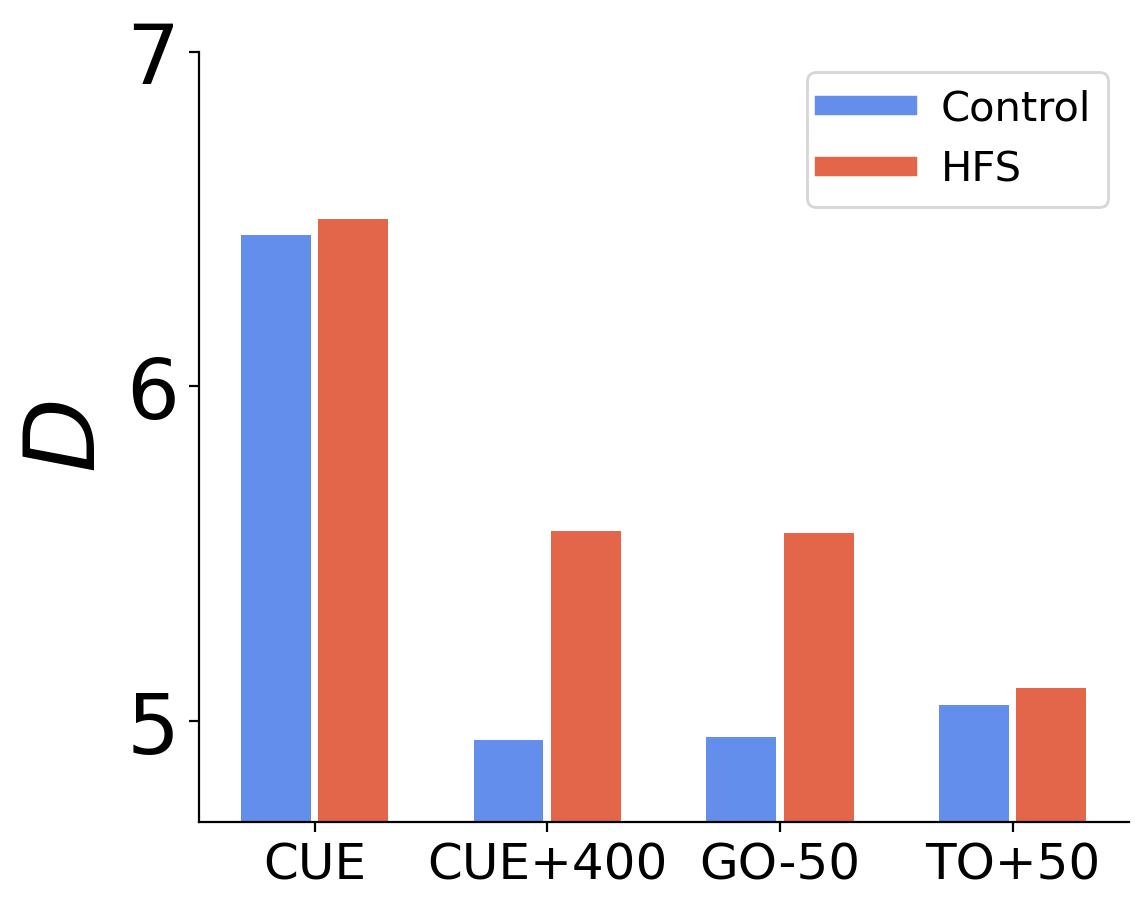

In [4]:
fig, ax = plt.subplots(figsize = (6,5), dpi = 200)

xpos = np.array([-0.5,0.5])

colors = ['#648eebff', '#e4664aff']

cue_ind = 0
cue_ind_400 = 1
go_ind = 0
to_ind = 0


Y_cue = [Dpca_cont_cue[cue_ind].mean(), Dpca_hfs_cue[cue_ind].mean()]
Yerr_cue = [Dpca_cont_cue[cue_ind].std(), Dpca_hfs_cue[cue_ind].std()]

Y_cue_400 = [Dpca_cont_cue[cue_ind_400].mean(), Dpca_hfs_cue[cue_ind_400].mean()]
Yerr_cue_400 = [Dpca_cont_cue[cue_ind_400].std(), Dpca_hfs_cue[cue_ind_400].std()]

Y_go = [Dpca_cont_go[go_ind].mean(), Dpca_hfs_go[go_ind].mean()]
Yerr_go = [Dpca_cont_go[go_ind].std(), Dpca_hfs_go[go_ind].std()]

Y_to = [Dpca_cont_to[to_ind].mean(), Dpca_hfs_to[to_ind].mean()]
Yerr_to = [Dpca_cont_to[to_ind].std(), Dpca_hfs_to[to_ind].std()]


#ax.bar(xpos, Y_cue , yerr = Yerr_cue, capsize = 10, color = colors, label = ['cont', 'HFS'])
#ax.bar(xpos+3, Y_cue_400 , yerr = Yerr_cue_400, capsize = 10, color = colors)
#ax.bar(xpos+6, Y_go , yerr = Yerr_go, capsize = 10, color = colors)
#ax.bar(xpos+9, Y_to , yerr = Yerr_to, capsize = 10, color = colors)


ax.bar(xpos, Y_cue , capsize = 10, color = colors, label = ['cont', 'HFS'], width = 0.9)
ax.bar(xpos+3, Y_cue_400 , capsize = 10, color = colors, width = 0.9)
ax.bar(xpos+6, Y_go , capsize = 10, color = colors, width = 0.9)
ax.bar(xpos+9, Y_to ,capsize = 10, color = colors, width = 0.9)



legend_elements = [Line2D([0], [0], color='#648eebff', lw = 7 ,label='Control'),
                   Line2D([0], [0], color='#e4664aff', lw = 7,label='HFS')]
ax.legend(handles = legend_elements, fontsize = 15)

ax.set_ylim((4.7,7.0))
ax.set_ylabel('$D$', fontsize = 35)

ax.set_xticks([0,3,6,9])
ax.set_xticklabels(['CUE','CUE+400','GO-50','TO+50'], fontsize = 18)

ax.set_yticks([5,6,7])
ax.set_yticklabels([5,6,7],fontsize= 30)

ax.spines[['right', 'top']].set_visible(False)

#plt.savefig('Dpca_cont8_HFS8_cue_go_to.svg' , transparent=True, bbox_inches="tight")
#plt.savefig('Dpca_cont8_HFS8_cue_go_to.pdf' , transparent=True, bbox_inches="tight")

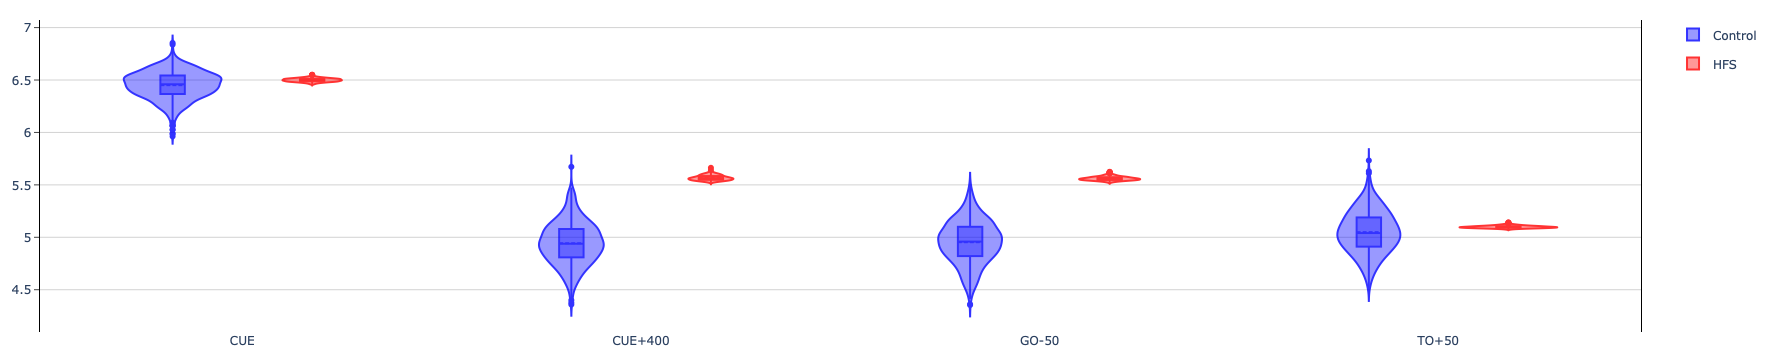

In [5]:
import plotly.graph_objects as go

import pandas as pd

labels = ['CUE','CUE+400','GO-50','TO+50']

df_cont = pd.DataFrame()
df_cont['dpca'] = np.concatenate((Dpca_cont_cue, Dpca_cont_go, Dpca_cont_to)).ravel()
df_cont['time'] = np.array([[labels[i]]*1000 for i in range(len(labels))]).ravel()

df_hfs = pd.DataFrame()
df_hfs['dpca'] = np.concatenate((Dpca_hfs_cue, Dpca_hfs_go, Dpca_hfs_to)).ravel()
df_hfs['time'] = np.array([[labels[i]]*1000 for i in range(len(labels))]).ravel()

df_cont['cond'] = 'Control'
df_hfs['cond'] = 'HFS'

df_tot = pd.concat([df_cont, df_hfs], ignore_index=True)


fig = go.Figure()

fig.add_trace(go.Violin(x=df_tot['time'][df_tot['cond']=='Control'],
                        y=df_tot['dpca'][df_tot['cond']=='Control'],
                        legendgroup='Control', scalegroup='Control', name='Control',
                        line_color='blue', opacity = 0.8, width = 0)
             )
fig.add_trace(go.Violin(x=df_tot['time'][ df_tot['cond'] == 'HFS' ],
                        y=df_tot['dpca'][ df_tot['cond'] == 'HFS' ],
                        legendgroup='HFS', scalegroup='HFS', name='HFS',
                        line_color='red', opacity = 0.8, width = 0)
             )


fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(violinmode='group', margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="white", plot_bgcolor = 'white'
)

fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()
#fig.write_image('dpca_violin.pdf', width = 3000, height = 400)
#fig.write_image('dpca_violin.svg', width = 3000, height = 400)

In [6]:
(Dpca_hfs_cue.mean(axis = 1) - Dpca_cont_cue.mean(axis = 1))/(np.sqrt(Dpca_hfs_cue.std(axis = 1)**2 + Dpca_cont_cue.std(axis = 1)**2))

array([0.37066531, 3.08409311])

In [7]:
(Dpca_hfs_go.mean(axis = 1) - Dpca_cont_go.mean(axis = 1))/(np.sqrt(Dpca_hfs_go.std(axis = 1)**2 + Dpca_cont_go.std(axis = 1)**2))

array([2.95865019])

In [8]:
(Dpca_hfs_to.mean(axis = 1) - Dpca_cont_to.mean(axis = 1))/(np.sqrt(Dpca_hfs_to.std(axis = 1)**2 + Dpca_cont_to.std(axis = 1)**2))

array([0.24554132])

In [9]:
snr = [0.37066531, 3.08409311, 2.95865019, 0.24554132]

from scipy.stats import norm
1-norm.cdf(snr)

array([0.35544342, 0.00102087, 0.00154495, 0.40301866])

# Drawing the neural states CONT8/HFS8

In [16]:
neur_states = np.load('neur_states_CONT8HFS8.npy')

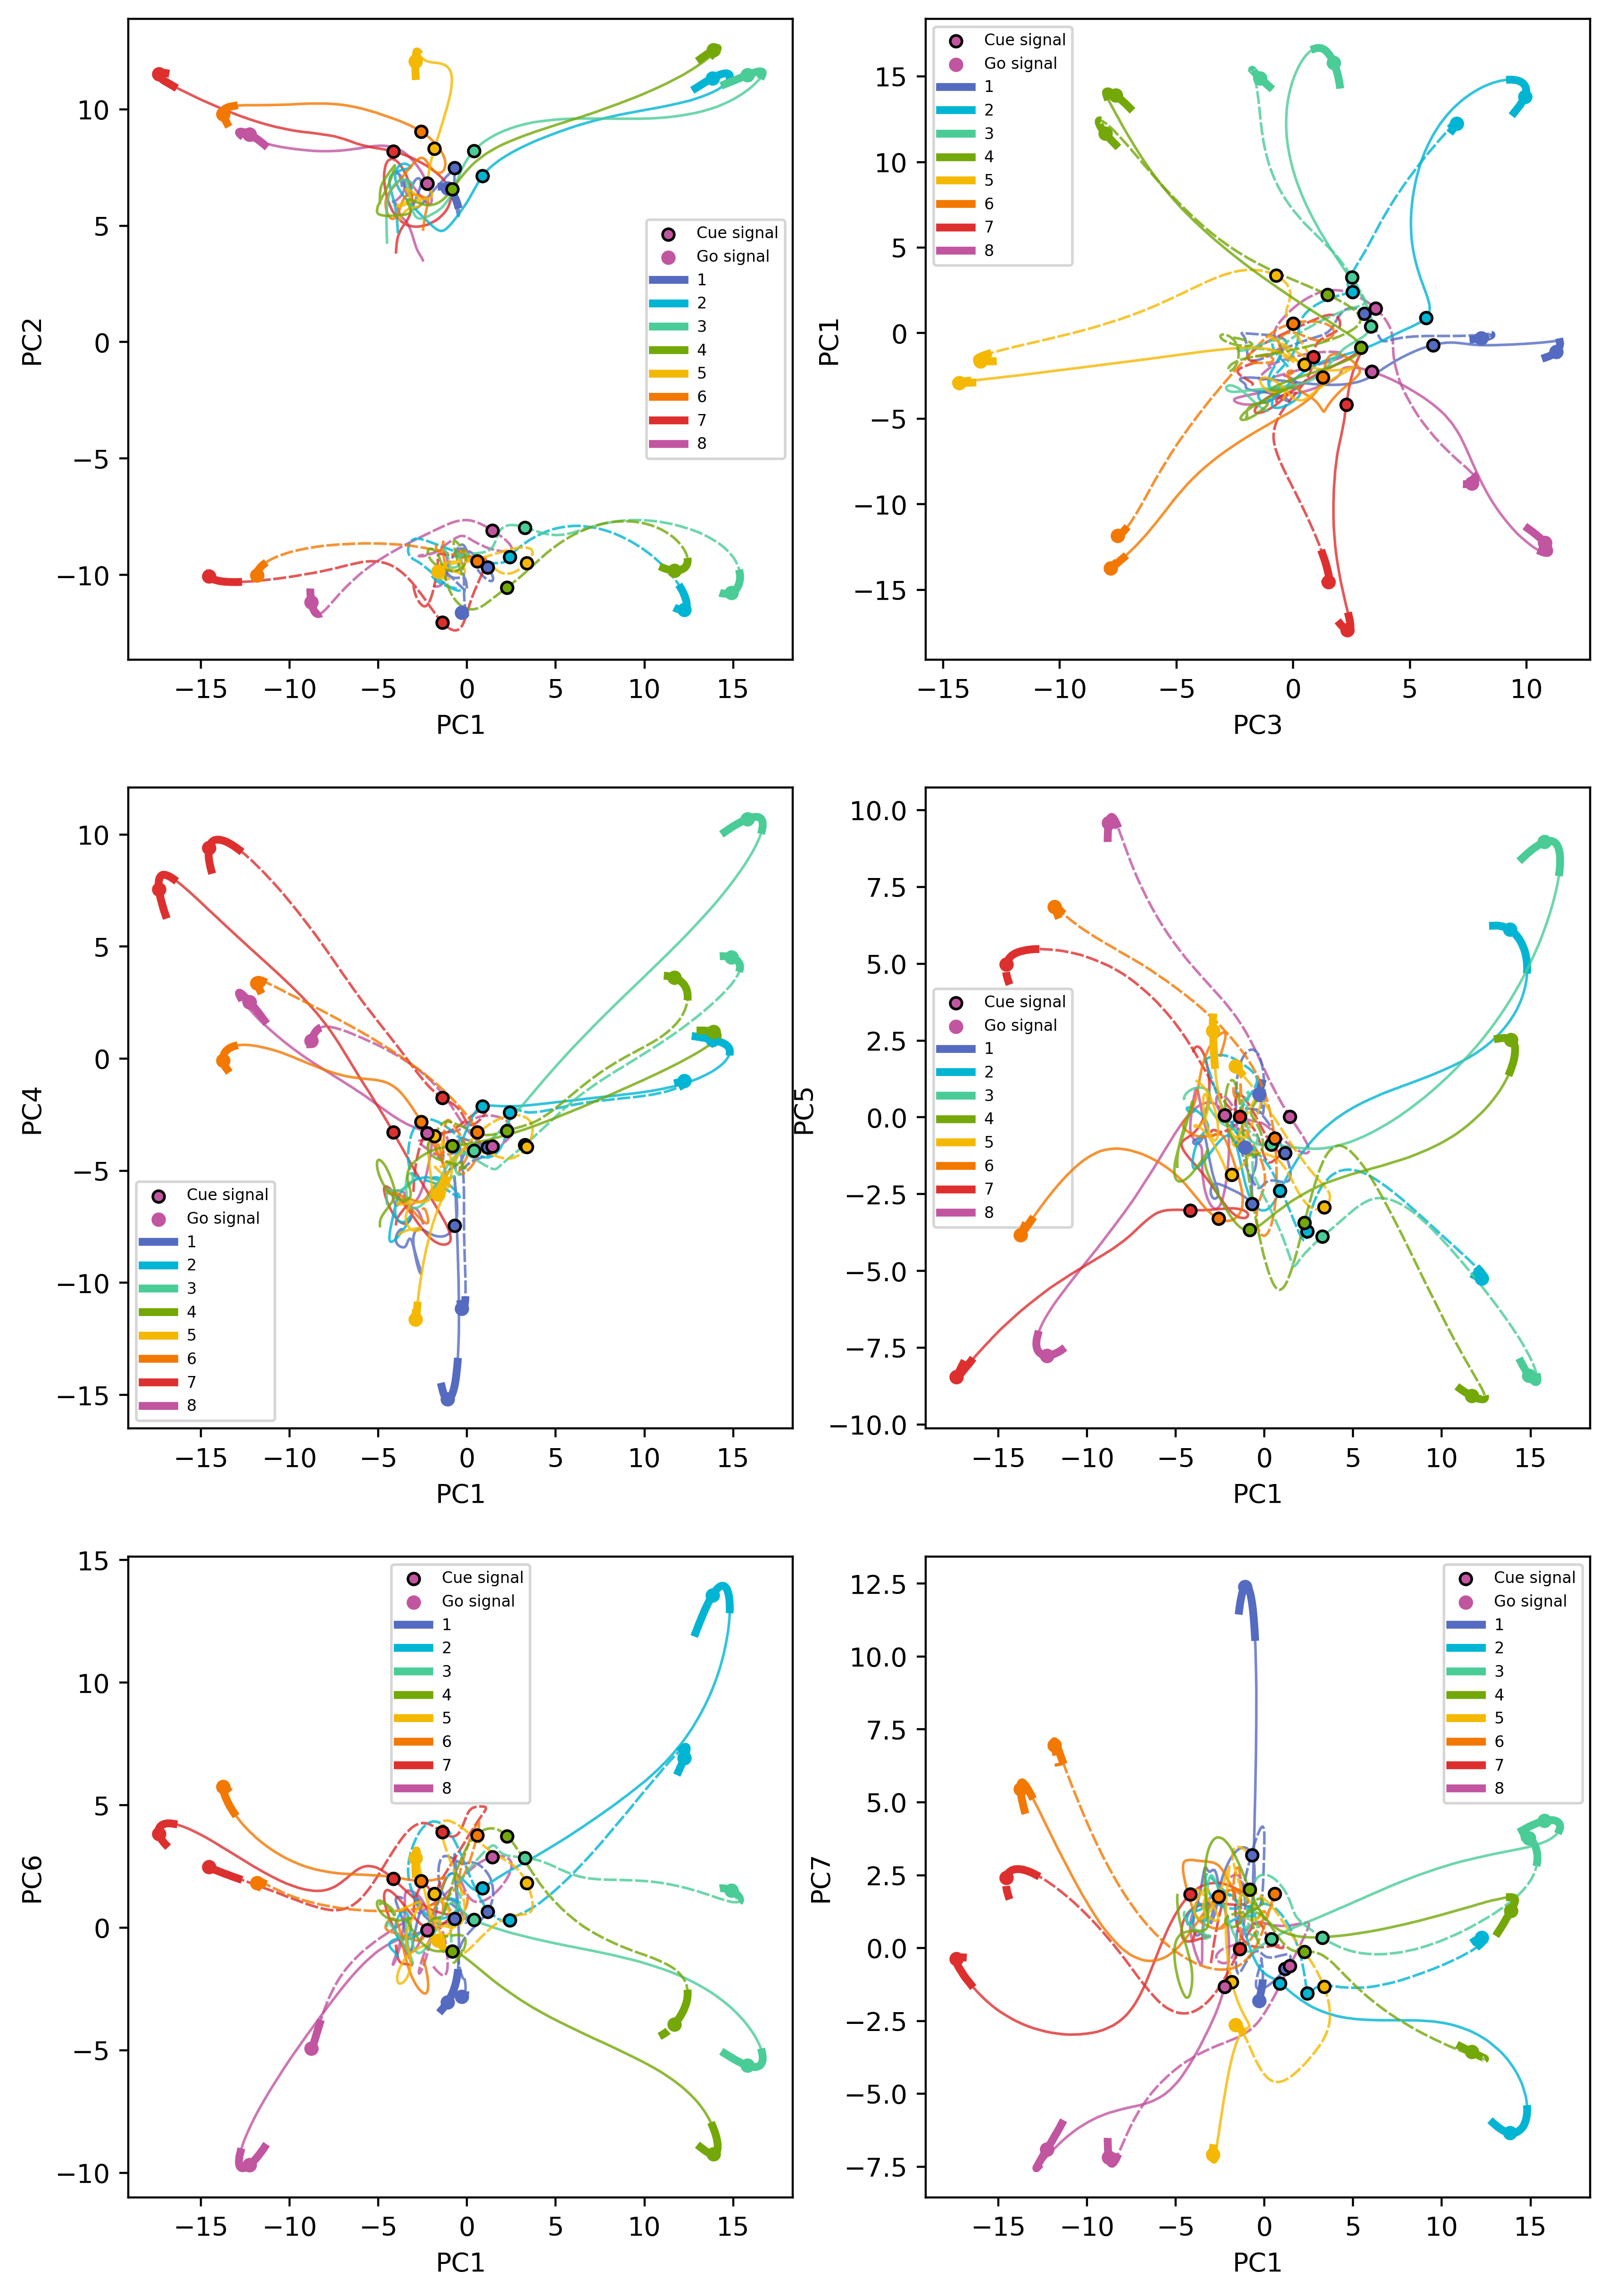

In [18]:
fig, ax = plt.subplots(3, 2, figsize = (10,15), dpi = 400)
colors = np.array([(85, 107, 194), (0, 182, 212), (74, 205, 152),(115, 169, 8), (245, 185, 0), (244, 120, 0), (223, 47, 47), (194, 85, 161)])/256 # ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']   
zordr = np.array([1,3,5,7,6,4,2,0])+100

t= 1900
window_size = 150



for row in range(3):
    for col in range(2):
        PC_ref = 0
        i = 7
        PCnumber = col+row*2+1
        
        if PCnumber == 2:
            PCnumber ,PC_ref = PC_ref, PCnumber
            ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k', label = 'Cue signal')
            ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200, label = 'Go signal')

            for i in range(8):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i], zorder = zordr[i])
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i], label=i+1 , zorder = zordr[i])
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200)


            for i in range(8,16):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i%8], zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i%8] , zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i%8], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i%8],marker = 'o', s = 20 , zorder=200)

            ax[row,col].set_xlabel('PC%d'%(PC_ref+1))
            ax[row,col].set_ylabel('PC%d'%(PCnumber+1))
                
        else:
            ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k', label = 'Cue signal')
            ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200, label = 'Go signal')

            for i in range(8):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i], zorder = zordr[i])
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i], label=i+1 , zorder = zordr[i])
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200)


            for i in range(8,16):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i%8], zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i%8] , zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i%8], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i%8],marker = 'o', s = 20 , zorder=200)

            ax[row,col].set_xlabel('PC%d'%(PC_ref+1))
            ax[row,col].set_ylabel('PC%d'%(PCnumber+1))


        #origin = np.array([-11, -5])
        #xhat = np.array([3, 0])
        #yhat = np.array([0, 3])

        # Plotting 2 unit vectors
        #ax[row,col].arrow(*origin, *xhat, head_width=0.2, color='k')
        #ax[row,col].arrow(*origin, *yhat, head_width=0.2, color='k')
        #ax[row,col].text(-10.5, -6, r'PC1', size = 10)
        #ax[row,col].text(-13.5, -4, r'PC%d'%(PCnumber+1), size = 10)
        ax[row,col].legend(fontsize=6)



#plt.savefig('PCA_cont8_hfs8_6PCs_prep_phase_reordered.pdf', transparent=True, bbox_inches="tight")

# Drawing neural states for Control 8

In [20]:
neur_states = np.load('neur_states_CONT8.npy')

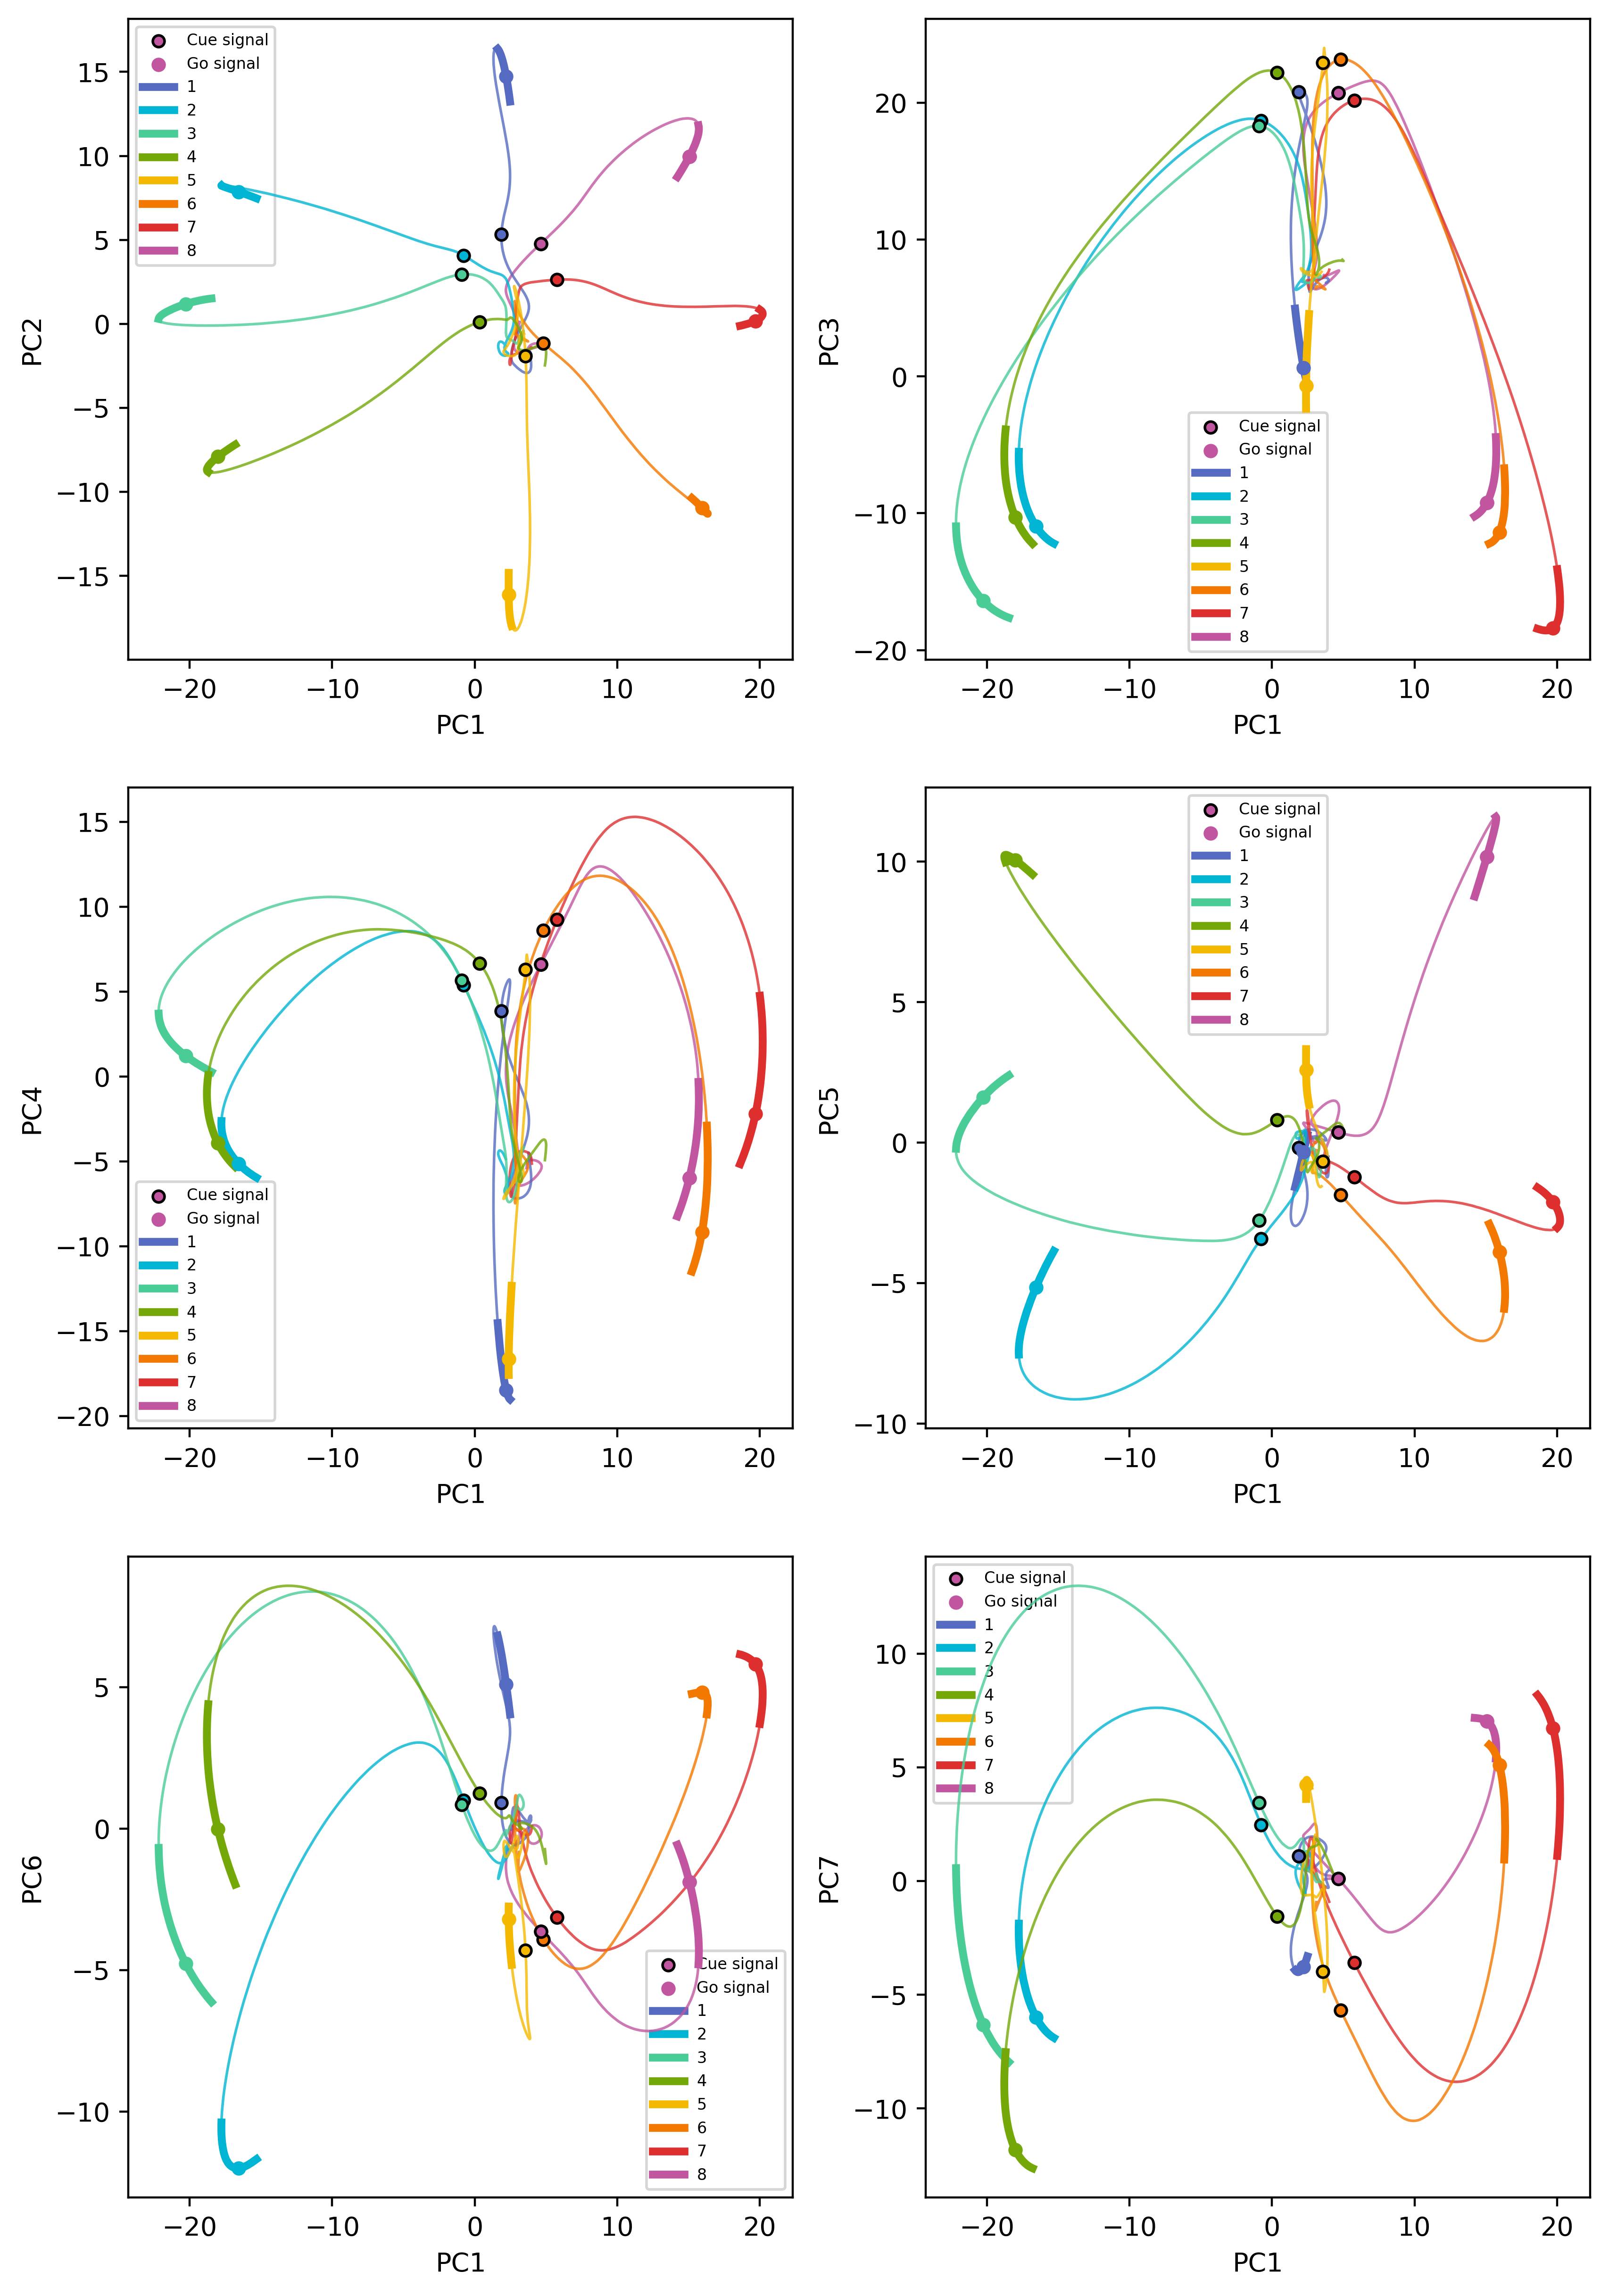

In [21]:
fig, ax = plt.subplots(3, 2, figsize = (10,15), dpi = 400)
colors = np.array([(85, 107, 194), (0, 182, 212), (74, 205, 152),(115, 169, 8), (245, 185, 0), (244, 120, 0), (223, 47, 47), (194, 85, 161)])/256 # ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']   
zordr = np.array([1,3,5,7,6,4,2,0])+100





for row in range(3):
    for col in range(2):
        PC_ref = 0
        i = 7
        PCnumber = col+row*2+1
        
        if PCnumber == 2:
            #PCnumber ,PC_ref = PC_ref, PCnumber
            ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k', label = 'Cue signal')
            ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200, label = 'Go signal')

            for i in range(8):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i], zorder = zordr[i])
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i], label=i+1 , zorder = zordr[i])
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200)


            ax[row,col].set_xlabel('PC%d'%(PC_ref+1))
            ax[row,col].set_ylabel('PC%d'%(PCnumber+1))
                
        else:
            ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k', label = 'Cue signal')
            ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200, label = 'Go signal')

            for i in range(8):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i], zorder = zordr[i])
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i], label=i+1 , zorder = zordr[i])
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200)
            ax[row,col].set_xlabel('PC%d'%(PC_ref+1))
            ax[row,col].set_ylabel('PC%d'%(PCnumber+1))


        #origin = np.array([-11, -5])
        #xhat = np.array([3, 0])
        #yhat = np.array([0, 3])

        # Plotting 2 unit vectors
        #ax[row,col].arrow(*origin, *xhat, head_width=0.2, color='k')
        #ax[row,col].arrow(*origin, *yhat, head_width=0.2, color='k')
        #ax[row,col].text(-10.5, -6, r'PC1', size = 10)
        #ax[row,col].text(-13.5, -4, r'PC%d'%(PCnumber+1), size = 10)
        ax[row,col].legend(fontsize=6)



#plt.savefig('PCA_cont8_hfs8_6PCs_prep_phase_reordered_rev1.pdf', transparent=True, bbox_inches="tight")

# CCGP analysis

In [32]:
list_targets_to_classify = [[2,4,6,8], [1,3,5,7], [1,2,5,6], [2,3,6,7], [3,4,7,8], [4,5,8,1]]

all_diff_in_generalization = np.load('DIFF_CCGP_PCA_'+str([2, 4, 6, 8])+'40_HFS_thresh.npy')
for targets_to_classify in list_targets_to_classify[1:]:
    diff_in_generalization = np.load('DIFF_CCGP_PCA_'+str(targets_to_classify)+'40_HFS_thresh.npy')
    all_diff_in_generalization = np.concatenate((all_diff_in_generalization, diff_in_generalization), axis = 1)
    
all_ccgp = np.load('200_CCGP_PCA_'+str([2, 4, 6, 8])+'_40_HFS_thresh.npy')
for targets_to_classify in list_targets_to_classify[1:]:
    ccgp = np.load('200_CCGP_PCA_'+str(targets_to_classify)+'_40_HFS_thresh.npy')
    all_ccgp = np.concatenate((all_ccgp, ccgp), axis = 2)

In [33]:
CCGP_thresh = 0.2
dich_filter_high_cont_ccgp = (np.abs(all_ccgp.mean(axis = 0)[0] - 0.5) > CCGP_thresh)

better_than_chance_ccgp = np.abs(all_ccgp - 0.5)

In [34]:
from scipy.stats import wilcoxon


wilcoxon(all_diff_in_generalization.mean(axis = 0)[dich_filter_high_cont_ccgp])

WilcoxonResult(statistic=15.0, pvalue=0.004180908203125)

Text(0.5, 1.0, 'CCGP distance from chance level for both Control and HFS conditions \n for all 12 dichotomies')

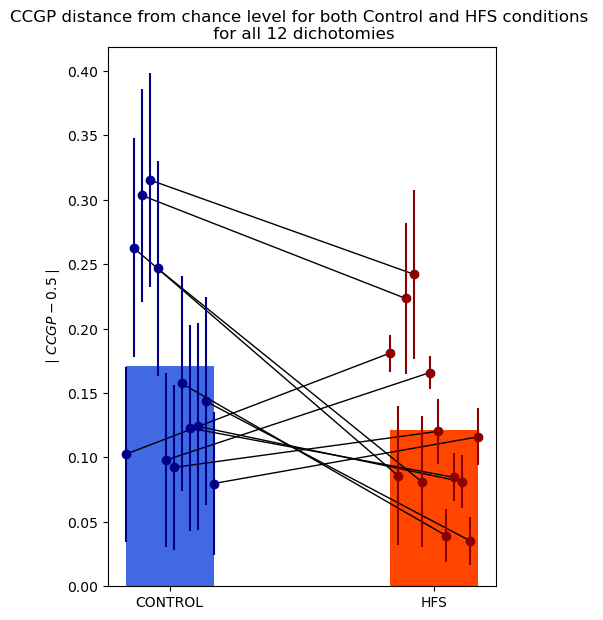

In [35]:
fig, ax = plt.subplots(figsize = (5,7))

better_than_chance_ccgp = np.abs(all_ccgp - 0.5)


ax.errorbar(np.linspace(-1,-0.5, 12), better_than_chance_ccgp.mean(axis = 0)[0,:12],
            yerr = better_than_chance_ccgp.std(axis = 0)[0,:12], marker = 'o', color ='darkblue', ls = 'None',
           zorder = -20)

ax.errorbar(np.linspace(0.5,1, 12), better_than_chance_ccgp.mean(axis = 0)[1,:12],
            yerr = better_than_chance_ccgp.std(axis = 0)[1,:12], marker = 'o', color ='darkred', ls = 'None',
           zorder = -20)




x_lines = np.array((np.linspace(-1,-0.5, 12), np.linspace(0.5,1, 12)))
y_lines = np.array((better_than_chance_ccgp.mean(axis = 0)[0,:12], 
                   better_than_chance_ccgp.mean(axis = 0)[1,:12]))

ax.plot(x_lines, y_lines, color = 'k',  zorder = -100, linewidth = 1)



ax.bar([-0.75,0.75], [better_than_chance_ccgp[:,0,:12].mean(),
                    better_than_chance_ccgp[:,1,:12].mean()], color = ['royalblue', 'orangered'], width = 0.5, zorder = -10000)


ax.set_xticks([-0.75, 0.75])
ax.set_xticklabels(['CONTROL', 'HFS'])

ax.set_ylabel('$ \mid CCGP - 0.5\mid$')

ax.set_title('CCGP distance from chance level for both Control and HFS conditions \n for all 12 dichotomies')

#plt.savefig('CCGP_dist_from_chance_12_dichotomies.pdf', bbox_inches="tight")